In [1]:
!pip install pgmpy

In [6]:
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch,MmhcEstimator
from pgmpy.estimators.CITests import chi_square
import networkx as nx
from pgmpy.estimators import BicScore ,K2Score, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianNetwork
import numpy as np
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from pgmpy.metrics import correlation_score

In [20]:
orderd_list = ['Age','Gender','Education','MaritalStatus','DistanceFromHome','WorkLifeBalance','TotalWorkingYears','JobLevel',
                'BusinessTravel','OverTime','PerformanceRating','JobSatisfaction','MonthlyIncome','Attrition']

 Estimates a DAG/PDAG from the given dataset using the PC algorithm which
        is a constraint-based structure learning algorithm[1]. The independencies
        in the dataset are identified by doing statistical independece test. This
        method returns a DAG/PDAG structure which is faithful to the independencies
        implied by the datase
The statistical tests use this value to compare with the p-value of the test to decide whether the tested variables are independent or not<br>
Types of test:
<ul>
<li> "chi_square": Uses the Chi-Square independence test. This works only for discrete datasets.
<li>"pearsonr": Uses the pertial correlation based on pearson correlation coefficient to test independence. This works only for continuous datasets.
</ul>

# Order Variables

Working for n conditional variables: 4: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


DAG with 8 nodes and 7 edges


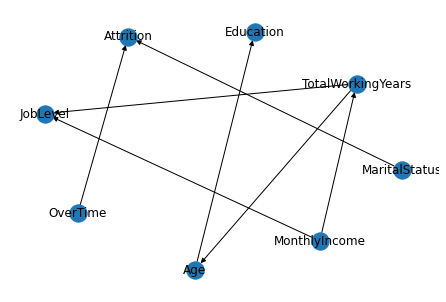

In [3]:
df = pd.read_csv("data/cleaning_dataset.csv")
pcest = PC(df)
pcmodel = pcest.estimate(variant = 'stable',max_cond_vars=4, significance_level=0.05)
print(pcmodel)
nx.draw(pcmodel, with_labels=True)

# Hill Climbing

## Correlation Matrix chi square

In [7]:
cols = df.columns
p_values = np.zeros((len(cols), len(cols)))
for first_index, first_col_val in enumerate(cols): 
    for second_index, second_col_val in enumerate(cols):
        if first_index != second_index:
            (chi, p_value, dof) = chi_square(first_col_val, second_col_val, [], df, False)
            p_values[first_index, second_index] = p_value

display(pd.DataFrame(p_values, columns=cols, index=cols).apply(np.log))

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PerformanceRating,TotalWorkingYears,WorkLifeBalance
Age,-inf,-22.740696,-1.039148,-2.791456,-51.975803,-209.963969,-0.072464,-6.107392,-122.459167,-1.295151,-0.257330,-355.619684,-0.065379
Attrition,-22.740696,-inf,-12.091207,-4.223994,-0.606006,-34.237255,-7.494202,-23.081838,-27.270011,-46.255236,-0.009975,-40.851214,-6.935569
BusinessTravel,-1.039148,-12.091207,-inf,-0.577524,-0.532532,-0.966097,-0.661752,-2.192671,-2.205608,-1.426898,-0.531619,-0.129714,-0.069215
DistanceFromHome,-2.791456,-4.223994,-0.577524,-inf,-0.086128,-1.639176,-0.136519,-1.157242,-0.807594,-1.582876,-2.709210,-1.675896,-0.064895
Education,-51.975803,-0.606006,-0.532532,-0.086128,-inf,-16.288140,-1.002704,-0.482621,-16.434348,-0.903363,-0.438111,-17.477097,-0.166011
JobLevel,-209.963969,-34.237255,-0.966097,-1.639176,-16.288140,-inf,-0.062962,-3.386753,-inf,-0.059707,-0.089660,-681.598728,-0.278890
JobSatisfaction,-0.072464,-7.494202,-0.661752,-0.136519,-1.002704,-0.062962,-inf,-0.188194,-0.246965,-1.213438,-1.347376,-0.295545,-0.384024
MaritalStatus,-6.107392,-23.081838,-2.192671,-1.157242,-0.482621,-3.386753,-0.188194,-inf,-2.197425,-0.408361,-0.097899,-5.526637,-0.620408
MonthlyIncome,-122.459167,-27.270011,-2.205608,-0.807594,-16.434348,-inf,-0.246965,-2.197425,-inf,-0.023468,-0.883640,-373.938535,-1.235510
OverTime,-1.295151,-46.255236,-1.426898,-1.582876,-0.903363,-0.059707,-1.213438,-0.408361,-0.023468,-inf,-0.072064,-1.257106,-0.699757


## HILL CLIMBING BAYESIAN NETWORK USING CHI SQUARE

  0%|          | 8/1000000 [00:01<45:25:03,  6.12it/s] 


-16957.62954195102
[('Age', 'Education'), ('Attrition', 'OverTime'), ('Attrition', 'MaritalStatus'), ('Attrition', 'BusinessTravel'), ('JobLevel', 'TotalWorkingYears'), ('JobLevel', 'Attrition'), ('MonthlyIncome', 'JobLevel'), ('TotalWorkingYears', 'Age')]


0.8041237113402062

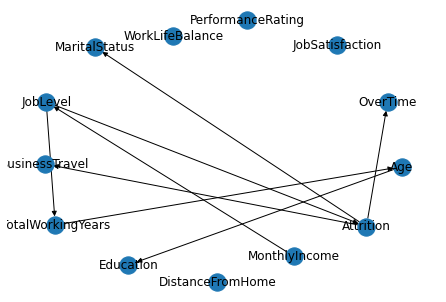

In [27]:
est = HillClimbSearch(df)
HC_first = est.estimate(scoring_method=BicScore(df))
nx.draw(HC_first, with_labels=True)
print(BicScore(df).score(HC_first))
print((HC_first.edges()))
correlation_score(HC_first, df, test="chi_square", significance_level=0.05)

## CORRELATION MATRIX K2 SCORE
LA DEVI METTERE TU

The K2 score is the result of setting all Dirichlet hyperparameters/pseudo_counts to 1.
The `score`-method measures how well a model is able to describe the given data set.

  0%|          | 10/1000000 [00:01<36:28:53,  7.61it/s]


-16919.66087345071
10
[('Age', 'Education'), ('Attrition', 'OverTime'), ('Attrition', 'TotalWorkingYears'), ('Attrition', 'MaritalStatus'), ('Attrition', 'BusinessTravel'), ('Attrition', 'JobSatisfaction'), ('Attrition', 'WorkLifeBalance'), ('JobLevel', 'MonthlyIncome'), ('TotalWorkingYears', 'JobLevel'), ('TotalWorkingYears', 'Age')]


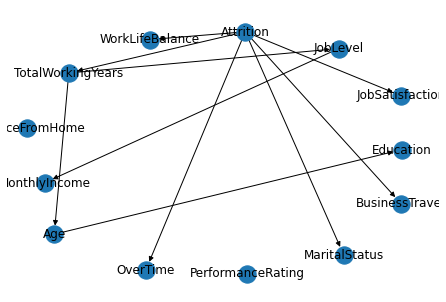

In [26]:
est = HillClimbSearch(df)
HC_firstK2 = est.estimate(scoring_method=K2Score(df))
nx.draw(HC_firstK2, with_labels=True)
print(K2Score(df).score(HC_firstK2))
print(len(HC_firstK2.edges()))
print(HC_firstK2.edges)

Ho aggiunto archi significativi cioè archi di cui i precedenti modelli non riescono ad estrarre informazioni
Per esempio ho aggiunto archi che danno informazioni ai nodi che non hanno archi come: PerformanceRating,DistanceFromHome....

In [13]:
edges = [("DistanceFromHome","WorkLifeBalance"),
         ("DistanceFromHome","JobSatisfaction"),
         ("WorkLifeBalance","JobSatisfaction"),
         ("WorkLifeBalance","PerformanceRating"),
         ("MaritalStatus","WorkLifeBalance"),
         ("PerformanceRating","MonthlyIncome"),
         ("PerformanceRating","JobSatisfaction"),
         ("OverTime","Attrition"),
         ("JobLevel","MonthlyIncome"),
        ]
print(len(edges))

9


## Using fixed edges, Hill Climbing Bic Score

  0%|          | 6/1000000 [00:01<47:58:08,  5.79it/s] 


{('TotalWorkingYears', 'JobLevel'), ('Attrition', 'BusinessTravel'), ('Attrition', 'MaritalStatus'), ('Age', 'Education'), ('Attrition', 'TotalWorkingYears'), ('TotalWorkingYears', 'Age')}


0.22222222222222224

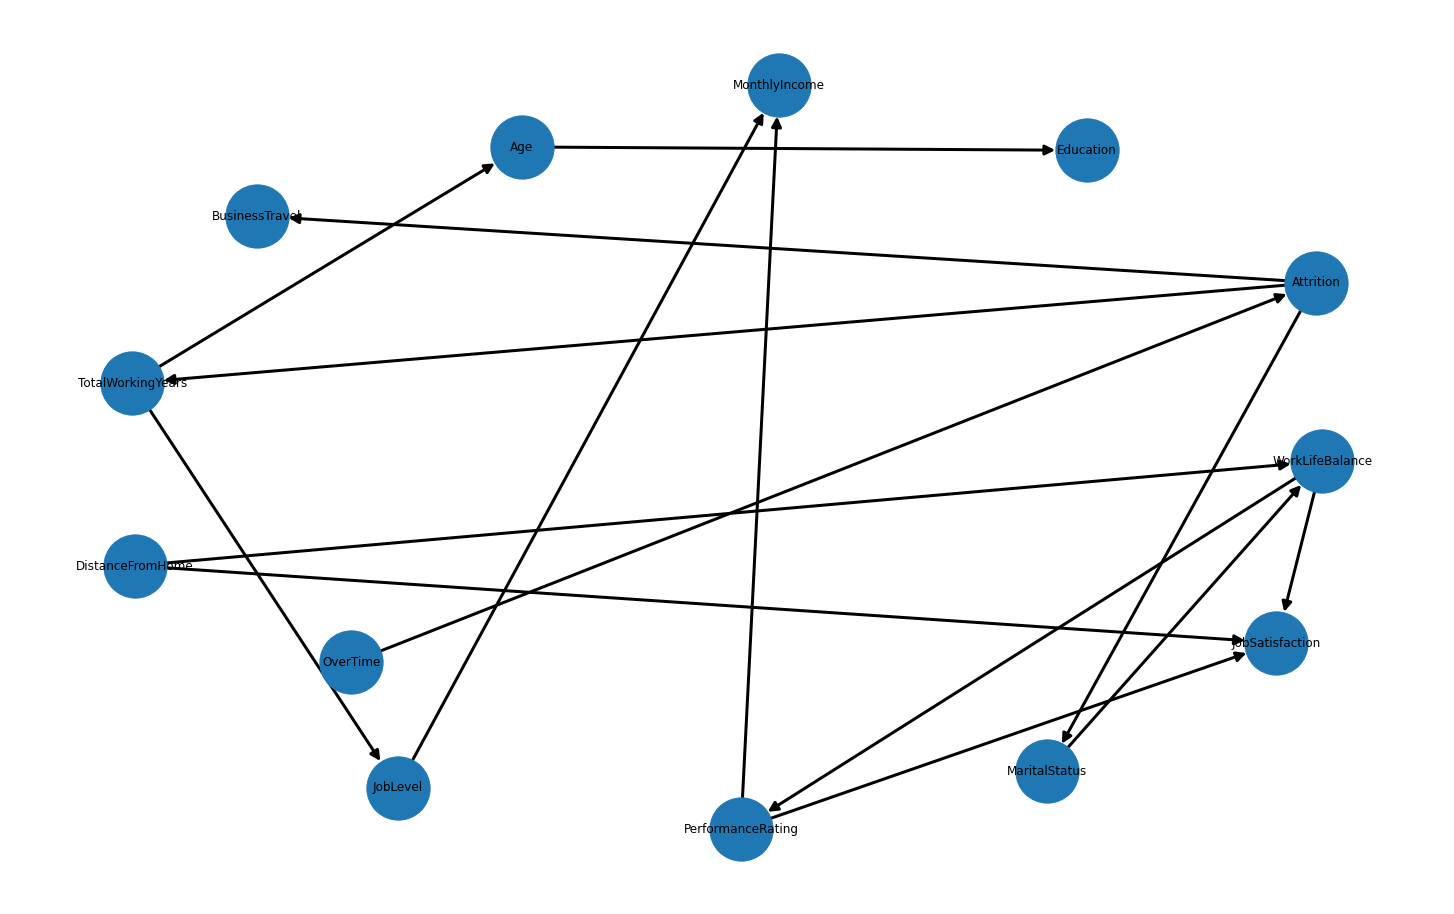

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
model_fixed_edges = est.estimate(scoring_method=BicScore(df),fixed_edges= edges)
nx.draw(model_fixed_edges, with_labels=True,node_size=4000, width=3, arrowsize=20)
print((model_fixed_edges.edges())-edges)
correlation_score(model_fixed_edges, df, test="chi_square", significance_level=0.05)

## Using fixed edges, Hill Climbing K2 Score

  0%|          | 6/1000000 [00:01<51:45:59,  5.37it/s] 


{('TotalWorkingYears', 'JobLevel'), ('Attrition', 'BusinessTravel'), ('Attrition', 'MaritalStatus'), ('Age', 'Education'), ('Attrition', 'TotalWorkingYears'), ('TotalWorkingYears', 'Age')}


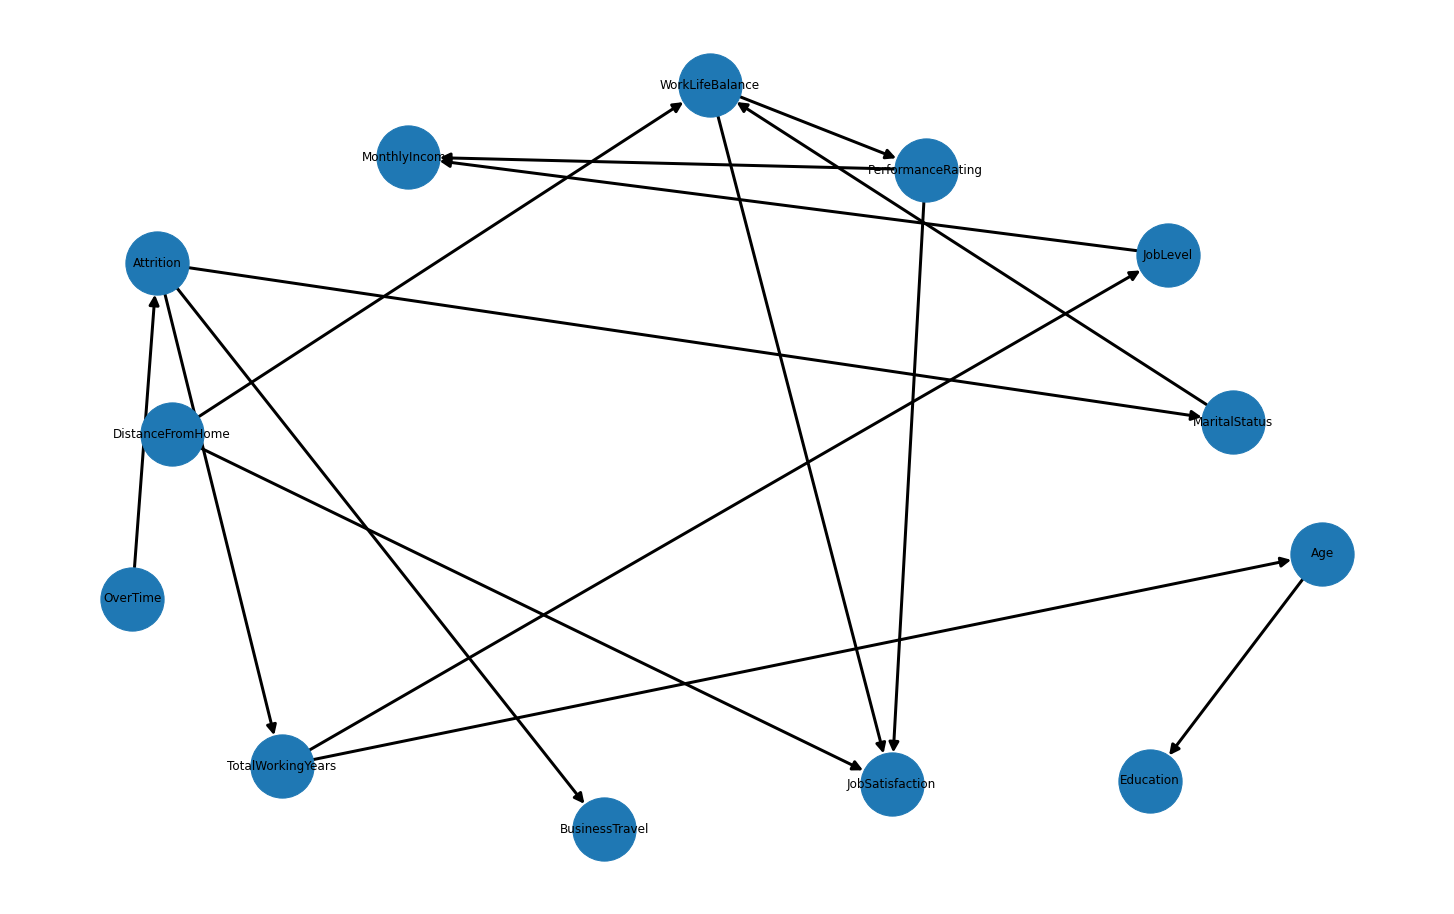

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
model_fixed_edges_K2 = est.estimate(scoring_method=K2Score(df),fixed_edges= edges)
nx.draw(model_fixed_edges_K2, with_labels=True,node_size=4000, width=3, arrowsize=20)
print((model_fixed_edges_K2.edges())-edges)
#correlation_score(model_fixed_edges_K2, df, test="K2", significance_level=0.05)

## Using Ordered List to improve final Result

In [22]:
# Using black list
black_list = []
for i in range(0,len(orderd_list)):
    for j in range(0,i):
        black_list.append((orderd_list[i],orderd_list[j]))

#print(black_list)

  0%|          | 4/1000000 [00:00<37:30:08,  7.41it/s] 


{('TotalWorkingYears', 'JobLevel'), ('Age', 'TotalWorkingYears'), ('JobLevel', 'Attrition'), ('Age', 'Education')}


0.7766990291262137

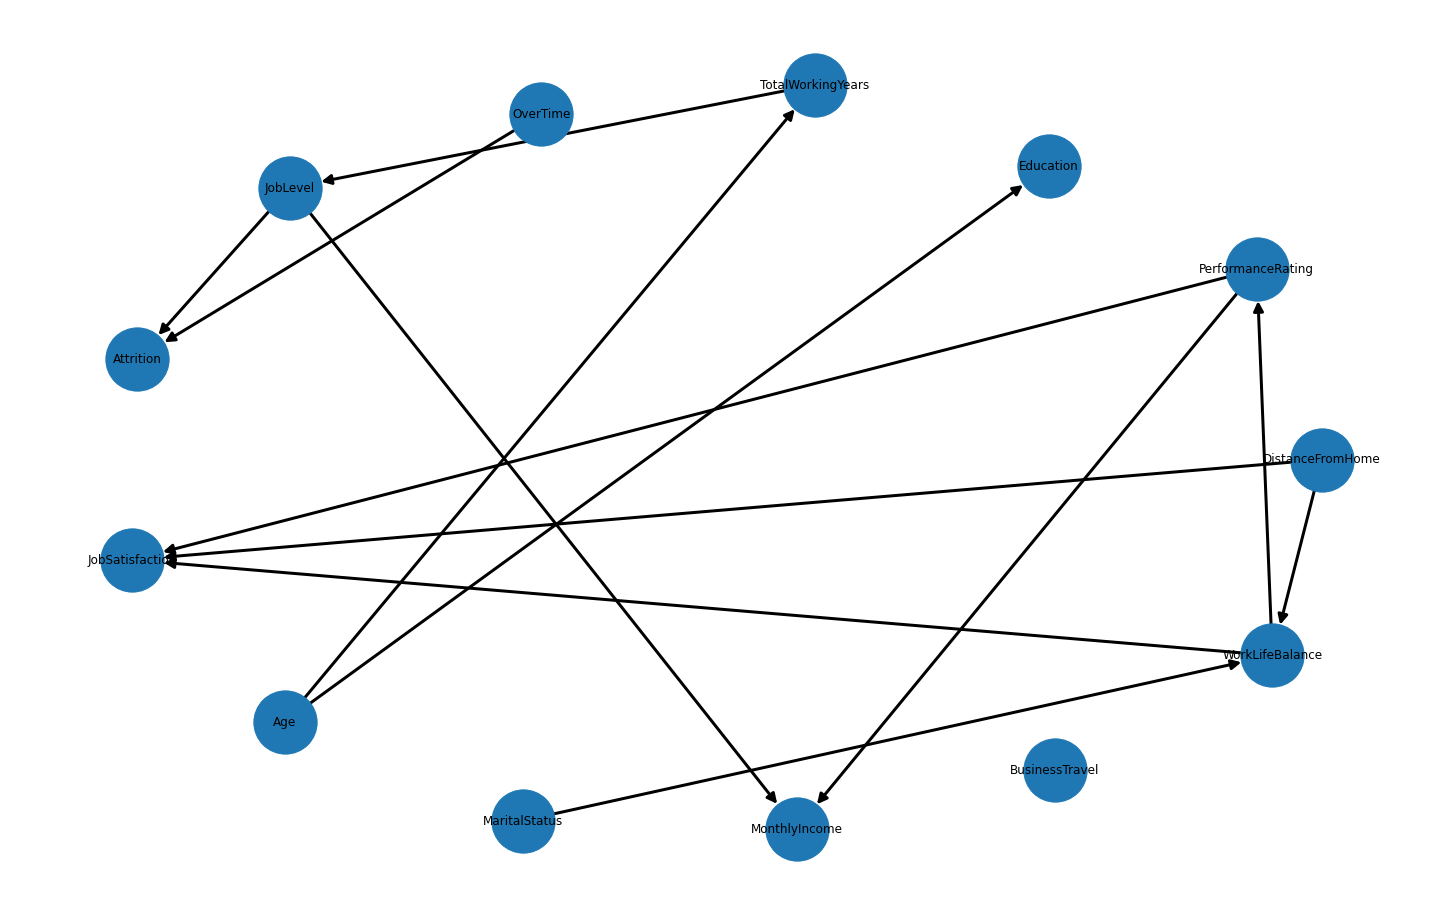

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
last_model_bic = HillClimbSearch(df)
last_model_bic = est.estimate(scoring_method=BicScore(df),fixed_edges=edges, black_list=black_list)
nx.draw(last_model_bic, with_labels=True,node_size=4000, width=3, arrowsize=20)
print((last_model_bic.edges())-edges)
correlation_score(last_model_bic, df, test="chi_square", significance_level=0.05)

  0%|          | 4/1000000 [00:00<35:40:01,  7.79it/s] 


{('TotalWorkingYears', 'JobLevel'), ('Age', 'TotalWorkingYears'), ('JobLevel', 'Attrition'), ('Age', 'Education')}


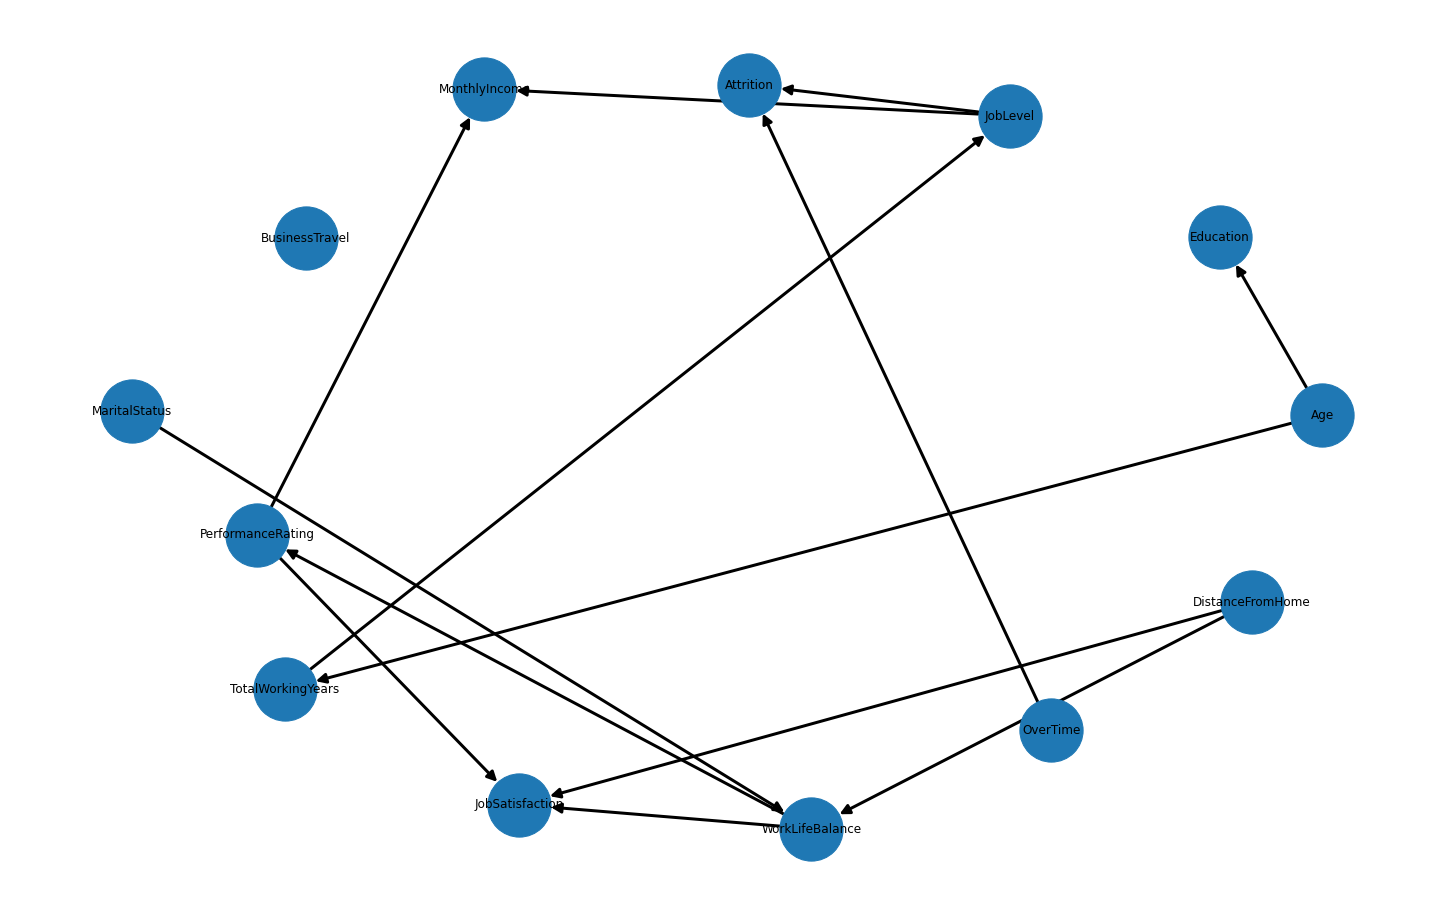

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
last_model_K2 = est.estimate(scoring_method=K2Score(df),fixed_edges=edges, black_list=black_list)
nx.draw(last_model_K2, with_labels=True,node_size=4000, width=3, arrowsize=20)
print((last_model_K2.edges())-edges)

Si può notare che nell'uso del Bic e del K2 ci sono differenze solamente nei primi modelli, nel momento in cui si usano i fixed age e black list i modelli costruiti rimangono uguali
Utilizziamo il modello migliore e costruiamo le cpd andando ad usare differenti stimatori per "fittare i dati" (calcolare le prior probabilities)

### Likelihood

In [32]:
bn_likelihood = BayesianNetwork(last_model_bic.edges())
bn_likelihood.fit(df, estimator=MaximumLikelihoodEstimator)
cpds = bn_likelihood.get_cpds()
for cpd in cpds:
    print(cpd)

+-----------------+----------+
| Age(Middle-age) | 0.423129 |
+-----------------+----------+
| Age(Senior)     | 0.355102 |
+-----------------+----------+
| Age(Young)      | 0.221769 |
+-----------------+----------+
+-------------------------------+-----+---------------------+
| Age                           | ... | Age(Young)          |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Beginner)   | ... | 0.4723926380368098  |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Competent)  | ... | 0.27300613496932513 |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Expert)     | ... | 0.0                 |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Novice)     | ... | 0.254601226993865   |
+-------------------------------+-----+---------------------+
| TotalWorkingYears(Proficient) | ... | 0.0                 |
+-------------------------------+-----+

### Bayesian Estimator

In [33]:
bn_bayesian = BayesianNetwork(last_model_bic.edges())
bn_bayesian.fit(df, estimator=BayesianEstimator)
cpds = bn_bayesian.get_cpds()
for cpd in cpds:
    print(cpd)

+-----------------+----------+
| Age(Middle-age) | 0.422825 |
+-----------------+----------+
| Age(Senior)     | 0.355028 |
+-----------------+----------+
| Age(Young)      | 0.222147 |
+-----------------+----------+
+-------------------------------+-----+----------------------+
| Age                           | ... | Age(Young)           |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Beginner)   | ... | 0.47100712105798576  |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Competent)  | ... | 0.2726347914547304   |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Expert)     | ... | 0.001017293997965412 |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Novice)     | ... | 0.25432349949135297  |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Proficient) | ... | 0.001017293997965412 |
+--------------------------